In [1]:
import jax
import numpy as np
import jax.numpy as jnp
from functools import partial
from jax import jacfwd, jacrev
import matplotlib.pyplot as plt
import jax.scipy.linalg as jlinalg

jax.config.update("jax_enable_x64", True)
jax.config.update('jax_platform_name', 'cpu')

from parsmooth import MVNStandard
from parsmooth import FunctionalModel
from parsmooth.sequential._filtering import filtering
from parsmooth.sequential._smoothing import smoothing
from parsmooth.linearization import extended, extended_hessian
from parsmooth.sequential._filtering_Newton import filtering as newton_filtering
from parsmooth.sequential._smoothing_Newton import smoothing as newton_smoothing

In [2]:
# Model parameters from "Temporal parallelization of Bayesian smoothers" paper.
T = 2000

dt = 0.1
sigma = 0.5
q = 1
F = np.array ([[1, 0, dt, 0 ],
               [0, 1, 0,  dt],
               [0, 0, 1,  0 ],
               [0, 0, 0,  1 ]])
Q = q * np.array ([[dt**3/3,    0,         dt**2/2,   0      ],
                   [0,          dt**3/3,   0,         dt**2/2],
                   [dt**2/2,    0,         dt,        0      ],
                   [0,          dt**2/2,   0,         dt     ]])
H = np.array([[1, 0, 0, 0], [0, 1, 0, 0]])
R = np.array([[sigma**2, 0],[0, sigma**2]])
nx = Q.shape[0]
ny = R.shape[1]

m0 = np.array([0 , 0, 1., -1])
P0 = np.eye(4)

L0 = jlinalg.cholesky(P0, lower=True)
x0 = m0 + L0 @ np.random.normal(size=(m0.shape))

In [3]:
# Get data
chol_Q = jlinalg.cholesky(Q, lower=True)
chol_R = jlinalg.cholesky(R, lower=True)
xs = np.zeros((T+1,nx))
ys = np.zeros((T,ny))
x = x0
xs[0,:] = x0
for k in range(T):
    q_noise = chol_Q @ np.random.normal(size=(x.shape))
    x = F @ x + q_noise
    r_noise = chol_R @ np.random.normal(size=(ny,))
    y = H @ x +  r_noise
    xs[k+1,:] = x
    ys[k,:] = y


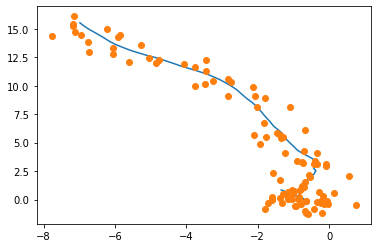

In [4]:
plt.figure()
plt.plot(xs[:,0][:100], xs[:,1][:100])
plt.plot(ys[:,0][:100], ys[:,1][:100], "o");

## Sequential solution

In [5]:
dynamic_model = lambda x: F @ x
measurement_model = lambda x: H @ x

In [6]:
init = MVNStandard(m0, P0)
initial_states =  MVNStandard(jnp.zeros((T+1, nx)), jnp.repeat(jnp.eye(nx).reshape(1, nx, nx), T+1, axis=0))
transition_model = FunctionalModel(partial(dynamic_model), MVNStandard(jnp.zeros((nx,)), Q))
observation_model = FunctionalModel(partial(measurement_model), MVNStandard(jnp.zeros((ny,)), R))

## Gauss-Newton

In [7]:
# Gauss-Newton
filtered_states = filtering(ys, init, transition_model, observation_model, extended, initial_states)
smoothed_results  = smoothing(transition_model, filtered_states, extended, initial_states)


## Newton

In [8]:
# Filtering - Newton
filtered_states_newton = newton_filtering(ys, init, transition_model, observation_model, extended_hessian, initial_states, True)
# Smoothing - Newton
smoothed_states_newton = newton_smoothing(transition_model, filtered_states_newton,  extended, initial_states)

# Batch solution

In [9]:
def mvn_loglikelihood(x, chol_cov):
    """multivariate normal"""
    dim = chol_cov.shape[0]
    y = jlinalg.solve_triangular(chol_cov, x, lower=True)
    normalizing_constant = (
            jnp.sum(jnp.log(jnp.abs(jnp.diag(chol_cov)))) + dim * jnp.log(2 * jnp.pi) / 2.0
    )
    norm_y = jnp.sum(y * y, -1)
    return -0.5 * norm_y - normalizing_constant

def LL(predict_trajectory, update_trajectory, z, measurement_fun, dynamic_fun, chol_Q, chol_R):
    mp_nominal = predict_trajectory
    mu_nominal = update_trajectory
    cost = mvn_loglikelihood(mu_nominal - dynamic_fun(mp_nominal), chol_Q) + mvn_loglikelihood(z - measurement_fun(mu_nominal), chol_R)
    return -cost

def state_space_cost(x):
    x0 = x[0]
    predict_traj =x[:-1]
    update_traj = x[1:]
    vmapped_fun = jax.vmap(LL, in_axes=[0, 0, 0, None, None, None, None])
    return jnp.sum(vmapped_fun(predict_traj, update_traj, ys, measurement_model, dynamic_model, jnp.linalg.cholesky(Q), jnp.linalg.cholesky(R))) - mvn_loglikelihood(x0 - m0, jnp.linalg.cholesky(P0))

grad = jax.grad(state_space_cost, argnums=0)(initial_states.mean)
Hess = jacfwd(jacrev(state_space_cost))(initial_states.mean)
x_batch = initial_states.mean - jax.numpy.linalg.tensorsolve(Hess, grad)

In [10]:
grad_reshape = jnp.reshape(grad, newshape=(grad.shape[0]*grad.shape[1], 1))

In [11]:
Hessian_reshape = jnp.reshape(Hess, newshape=(Hess.shape[0]*Hess.shape[1], Hess.shape[0]*Hess.shape[1]))

In [12]:
def _first_H(_x, _P0, _f, _F, _Fxx, _Q):
    _x0 = _x[0]
    _x1 = _x[1]
    inv_P0 = jnp.linalg.inv(_P0)
    inv_Q = jnp.linalg.inv(_Q)
    ddL_ddx0 = inv_P0 - jnp.tensordot(_Fxx(_x0).T, inv_Q @ (_x1 - _f(_x0)), axes=1) + _F(_x0).T @ inv_Q @ _F(_x0)
    ddL_dx0dx1 = - _F(_x0).T @ inv_Q
    return ddL_ddx0, ddL_dx0dx1


def _middle_H(_x, _Q, _R, _f, _F, _Fxx, _h, _H, _Hxx, _y):
    _x_k_1 = _x[0]
    _x_k = _x[1]
    _x_k_p_1 = _x[2]
    inv_Q = jnp.linalg.inv(_Q)
    inv_R = jnp.linalg.inv(_R)
    one = - inv_Q @ _F(_x_k_1)
    # two = inv_Q - _Hxx(_x_k).T @ inv_R @ (_y - _h(_x_k)) + _H(_x_k).T @ inv_R @ _H(_x_k)
    two = inv_Q - jnp.tensordot(_Hxx(_x_k).T, inv_R @ (_y - _h(_x_k)), axes=1)  + _H(_x_k).T @ inv_R @ _H(_x_k) - jnp.tensordot(_Fxx(_x_k).T, inv_Q @ (_x_k_p_1 - _f(_x_k)), axes=1)  + _F(_x_k).T @ inv_Q @ _F(_x_k)
    three = - _F(_x_k).T @ inv_Q
    return one, two, three

def _last_H(_x, _F, _Q, _h, _H, _Hxx, _R, _y):
    x_N_1 = _x[0]
    x_N = _x[1]
    inv_Q = jnp.linalg.inv(_Q)
    inv_R = jnp.linalg.inv(_R)
    ddL_dxN_dxN_1 = - inv_Q @ _F(x_N_1)
    ddL_ddxN = inv_Q - jnp.tensordot(_Hxx(x_N).T, inv_R @ (_y - _h(x_N)), axes=1) + _H(x_N).T @ inv_R @ _H(x_N)
    return ddL_dxN_dxN_1, ddL_ddxN

In [13]:
x_check_ = np.random.normal(size=(initial_states.mean.shape))
observation_function_dxx = jacfwd(jacrev(measurement_model))
transition_function_dxx = jacfwd(jacrev(dynamic_model))
observation_function_dx = jacfwd(measurement_model)
transition_function_dx = jacfwd(dynamic_model)
Hess_test = jacfwd(jacrev(state_space_cost))(x_check_)

In [14]:
i=10
np.testing.assert_array_almost_equal(_middle_H(x_check_[i - 1:i + 2, :], Q, R, dynamic_model, transition_function_dx, transition_function_dxx, measurement_model, observation_function_dx, observation_function_dxx, ys[i - 1])[1],
                                     Hess_test[i,:,i,:], decimal=10)

np.testing.assert_array_almost_equal(_middle_H(x_check_[i - 1:i + 2, :], Q, R, dynamic_model, transition_function_dx, transition_function_dxx, measurement_model, observation_function_dx, observation_function_dxx, ys[i - 1])[0],
                                     Hess_test[i,:,i-1,:], decimal=10)
np.testing.assert_array_almost_equal(_middle_H(x_check_[i - 1:i + 2, :], Q, R, dynamic_model, transition_function_dx, transition_function_dxx, measurement_model, observation_function_dx, observation_function_dxx, ys[i - 1])[2],
                                     Hess_test[i,:,i + 1,:], decimal=10)

In [15]:
np.testing.assert_array_almost_equal(smoothed_states_newton.mean, x_batch, decimal=9)
np.testing.assert_array_almost_equal(smoothed_results.mean, smoothed_states_newton.mean, decimal=9)


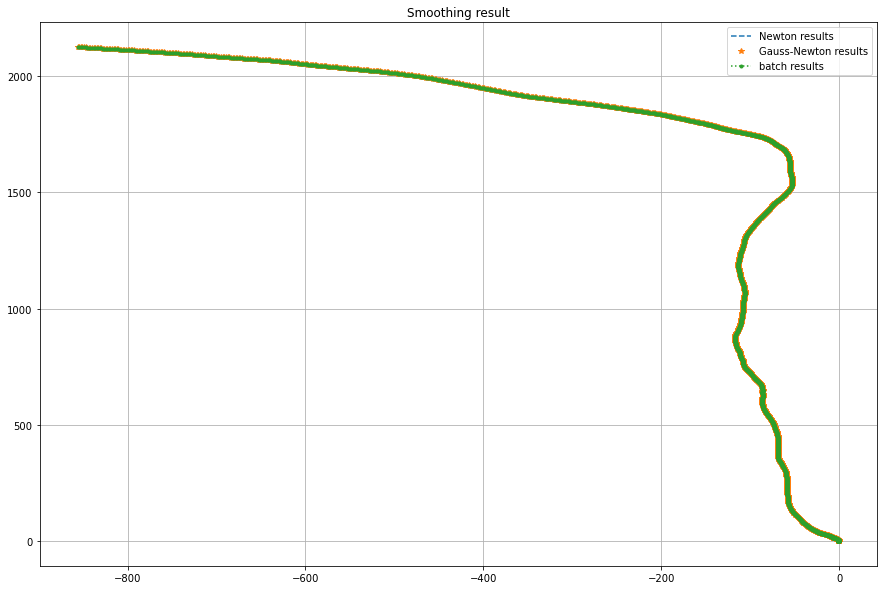

In [16]:
plt.figure(figsize=(15,10))
plt.plot(smoothed_states_newton.mean[:,0], smoothed_states_newton.mean[:,1], "--", label="Newton results" )
plt.plot(smoothed_results.mean[:,0], smoothed_results.mean[:,1], "*", label = "Gauss-Newton results")
plt.plot(x_batch[:,0],x_batch[:,1], ".:", label = "batch results")
plt.title("Smoothing result")
plt.grid()
plt.legend();